# Example: Estimating CATEs with a MetaLearner

## Loading the data

First, we will load and prepare some data for this example. In this
particular case we rely on the so-called mindset data set, taken from
[here](https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/learning_mindset.csv)
and under MIT License. It stems from an experimental setup where

* The outcome was the achievement of a student in scalar form, found
  in column ``"achievement_score".``
* The mindset intervention is a binary variable found in the column
  ``"intervention"``.
* Both numerical and categorical covariates/features are present.

In [1]:
import pandas as pd
from pathlib import Path
from git_root import git_root

df = pd.read_csv(git_root("data/learning_mindset.zip"))
outcome_column = "achievement_score"
treatment_column = "intervention"
feature_columns = [
    column
    for column in df.columns
    if column not in [outcome_column, treatment_column]
]
categorical_feature_columns = [
    "ethnicity",
    "gender",
    "frst_in_family",
    "school_urbanicity",
    "schoolid",
]
# Note that explicitly setting the dtype of these features to category
# allows both lightgbm as well as shap plots to
# 1. Operate on features which are not of type int, bool or float
# 2. Correctly interpret categoricals with int values to be
#    interpreted as categoricals, as compared to ordinals/numericals.
for categorical_feature_column in categorical_feature_columns:
    df[categorical_feature_column] = df[categorical_feature_column].astype(
        "category"
    )

Using a first, simple MetaLearner
---------------------------------

Now that the data has been loaded, we can get to actually using
MetaLearners. Let's start with the
{class}`~metalearners.TLearner`.
Investigating its documentation, we realize that only three initialization parameters
are necessary in the case we do not want to reuse nuisance models: ``nuisance_model_factory``, ``is_classification`` and
``n_variants``. Given that our outcome is a scalar, we want to set
``is_classification=False`` and use a regressor as the
``nuisance_model_factory``. In this case we arbitrarily choose a
regressor from ``lightgbm``. Since we know that the intervention was
binary, we set ``n_variants=2``.

In [2]:
from metalearners import TLearner
from lightgbm import LGBMRegressor

tlearner = TLearner(
    nuisance_model_factory=LGBMRegressor,
    is_classification=False,
    n_variants=2,
    nuisance_model_params={"verbose": -1}
)

Once our T-Learner has been instantiated, we can use it
in a fashion akin to scikit-learn's Estimator protocol. The subtle differences
to aforementioned scikit-learn protocol are that

* We need to specify the observed treatment assignment ``w`` in the call to the
  ``fit`` method.
* We need to specify whether we want in-sample or out-of-sample
 CATE estimates in the {meth}`~metalearners.TLearner.predict` call via ``is_oos``. In the
 case of in-sample predictions, the data passed to {meth}`~metalearners.TLearner.predict`
 must be exactly the same as the data that was used to call {meth}`~metalearners.TLearner.fit`.

In [3]:
tlearner.fit(
    X=df[feature_columns],
    y=df[outcome_column],
    w=df[treatment_column],
)

cate_estimates_tlearner = tlearner.predict(
    X=df[feature_columns],
    is_oos=False,
)

We can now notice that ``cate_estimates_tlearner`` is of shape
{math}`(n_{obs}, n_{variants} - 1, n_{outputs})`. This is meant to
cater to a general case, where there are more than two variants and/or
classification problems with many class probabilities. Given that we
care about the simple case of binary variant regression, we can make use of
{func}`~metalearners.utils.simplify_output` to simplify this shape as such:

In [4]:
from metalearners.utils import simplify_output
one_d_estimates = simplify_output(cate_estimates_tlearner)

print(cate_estimates_tlearner.shape)
print(one_d_estimates.shape)

(10391, 1, 1)
(10391,)


Using a MetaLearner with two stages
-----------------------------------

Instead of using a T-Learner, we can of course also use some other
MetaLearner, such as the {class}`~metalearners.RLearner`.
The R-Learner's documentation tells us that two more instantiation
parameters are necessary: ``propensity_model_factory`` and
``treatment_model_factory``. Hence we can instantiate an R-Learner as follows

In [5]:
from metalearners import RLearner
from lightgbm import LGBMClassifier
rlearner = RLearner(
    nuisance_model_factory=LGBMRegressor,
    propensity_model_factory=LGBMClassifier,
    treatment_model_factory=LGBMRegressor,
    is_classification=False,
    n_variants=2,
)

where we choose a classifier class to serve as a blueprint for our
eventual propensity model. It is important to notice that although we consider the propensity
model a nuisance model, the initialization parameters for it are separated from the other
nuisance parameters to allow a more understandable user interface, see the next code prompt.

In general, when initializing a MetaLearner, the ``nuisance_model_factory`` parameter will
be used to create all the nuisance models which are not a propensity model,  the
``propensity_model_factory`` will be used for the propensity model if the MetaLearner
contains one, and the ``treatment_model_factory`` will be used for the models predicting
the CATE. To see the models present in each MetaLearner type see
{meth}`~metalearners.metalearner.MetaLearner.nuisance_model_specifications` and
{meth}`~metalearners.metalearner.MetaLearner.treatment_model_specifications`.

In the {class}`~metalearners.RLearner` case, the ``nuisance_model_factory`` parameter will
be used to create the outcome model, the ``propensity_model_factory`` will be used for the
propensity model and the ``treatment_model_factory`` will be used for the model predicting
the CATE.

If we want to make sure these models are initialized in a specific
way, e.g. with a specific value for the hyperparameter ``n_estimators``, we can do that
as follows:

In [6]:
rlearner = RLearner(
    nuisance_model_factory=LGBMRegressor,
    propensity_model_factory=LGBMClassifier,
    treatment_model_factory=LGBMRegressor,
    is_classification=False,
    n_variants=2,
    nuisance_model_params={"n_estimators": 10, "verbose": -1},
    propensity_model_params={"n_estimators": 8, "verbose": -1},
    treatment_model_params={"n_estimators": 3, "verbose": -1},
)

The estimation steps look identical to those of the T-Learner:

In [7]:
rlearner.fit(
    X=df[feature_columns],
    y=df[outcome_column],
    w=df[treatment_column],
)

cate_estimates_rlearner = rlearner.predict(
    X=df[feature_columns],
    is_oos=False,
)

Comparing estimates
-------------------

We can now compare the CATE estimates produced by both MetaLearners on
a histogram:

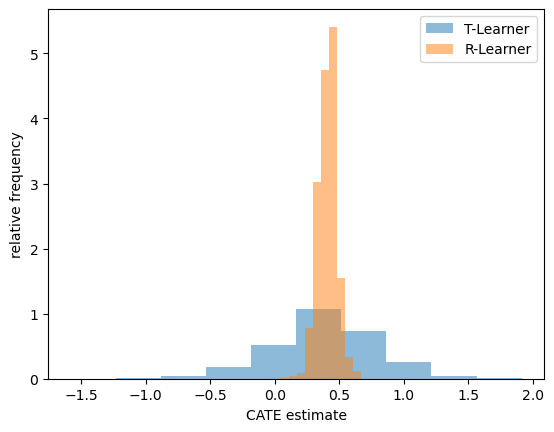

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(simplify_output(cate_estimates_tlearner), density=True, alpha=.5, label="T-Learner")
ax.hist(simplify_output(cate_estimates_rlearner), density=True, alpha=.5, label="R-Learner")
ax.legend()
ax.set_xlabel("CATE estimate")
ax.set_ylabel("relative frequency")
plt.show()